In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import ticker
rcParams["figure.figsize"] = (10,8)
plt.style.use("science")
import eispac
from glob import glob
import sunpy
from sunpy.io.special import read_genx
import cmcrameri.cm as cmcm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import interpolate
from scipy import ndimage
import juanfit
from juanfit import SpectrumFitSingle, SpectrumFitRow
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 18
rcParams['figure.figsize'] = [10,10]
rcParams['axes.linewidth'] = 2
from scipy.interpolate import interp1d
import astropy.constants as const
from num2tex import num2tex


In [2]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_b = const.k_B.cgs.value

In [3]:
class SpectrumFitCustomPlot(SpectrumFitSingle):
    def plot_custom(self, plot_fit=True,plot_params=True, plot_mcmc=False,plot_hmc=False,
                color_style="Red",plot_title=None,xlabel=None,ylabel=None,xlim=None,
                line_caption=None,save_fig=False,
                params_prec = {"int":2,"wvl":1,"fwhm":2,"cont":1},
                save_fname="./fit_result.pdf",save_fmt="pdf",save_dpi=300):
        '''
            Plot the input spectra and fitting results. 

            Parameters
            ----------
            plot_fit : bool, optional
            If True, plots the fitting results as well. Default is True.
            plot_params : bool, optional 
            If True, plot the fitted parameters by the figure. Default is True. 
            plot_mcmc : bool, optional 
            If True, plots the MCMC results. Default is False.
            plot_hmc: bool, optional 
            If True, plots the Monte Carlo fitting results using the method described in 
            Hahn et al. 2012, ApJ, 753, 36. Default is False. 
            xlim : [left limit, right_lim], optional 
            If provided, set the left and right limit of the x-axis. Default is None. 
            color_style : {"Red","Yellow","Green","Blue","Purple"}, optional
            Color style of the plot. Default is "Red".
            plot_title : string, optional 
            Set to be the title of the plot. Default is None.
            xlabel: string, optional 
            Set to be the label of the x-axis. Default is None.
            ylabel: string, optional 
            Set to be the label of the y-axis. Default is None. 
            save_fig: bool, optional 
            If True, save the plot to local directory. Default is False.
            save_fname: string, optional 
            The filename of the saved plot. Default is "./fit_result.pdf"
            save_fmt: string, optional 
            Format of the saved file, e.g., "pdf", "png", "svg"... Default is "pdf".
            save_dpi: int, optional
            Dots per inch (DPI) of the saved plot. Default is 300. 

        '''
        if (self.custom_func is not None) and (plot_params is True):
            warn("Use custom function in the fitting. Will not plot fitted parameters.")
            plot_params = False

        self.wvl_plot = np.linspace(self.wvl[0],self.wvl[-1],5*len(self.wvl))
        if (plot_fit is True) and (plot_params is True):
            fig = plt.figure(figsize=(8+3*np.ceil(self.line_number/2),8),constrained_layout=True)
            gs_fig = fig.add_gridspec(1, 2,figure=fig,width_ratios=[8., 3*np.ceil(self.line_number/2)])
            gs_plot = gs_fig[0].subgridspec(2, 1,height_ratios=[5,2])
            ax = fig.add_subplot(gs_plot[0])
            ax_res = fig.add_subplot(gs_plot[1])
        elif (plot_fit is True) and (plot_params is False):
            fig = plt.figure(figsize=(6,6.5))
            gs_plot = fig.add_gridspec(nrows=10, ncols=1,left=0.15, right=0.98,bottom=0.1,top=0.98,
                    hspace=0.)
            ax = fig.add_subplot(gs_plot[:7])
            ax_res = fig.add_subplot(gs_plot[7:])
        else:
            fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
        ax.tick_params(which="both",labelsize=18,right=True,top=True)
        #ax.set_xlabel("Wavelength",fontsize=18)
        if ylabel is None:
            ax.set_ylabel("Intensity",fontsize=18)
        else:
            ax.set_ylabel(ylabel,fontsize=18)
        ax.tick_params(which="major",width=1.2,length=8,direction="in")
        ax.tick_params(which="minor",width=1.2,length=4,direction="in")
        ax.tick_params(labelbottom=False)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.get_offset_text().set_fontsize(18)
        ax.yaxis.get_offset_text().set_y(1.05)
        #print("Wavelength:",self.line_wvl_fit)
        #print("Width:",self.fwhm_fit)
        #print("Width Error:",self.fwhm_err)

        if color_style == "Red":
            colors = ["#E87A90","#FEDFE1","black","#E9002D","#DBD0D0"]
        elif color_style == "Green":
            colors = ["#00896C","#A8D8B9","black","#33A6B8","#DBD0D0"]
        elif color_style == "Yellow":
            colors = ["#FFBA84","#FAD689","black","#FC9F4D","#DBD0D0"]
        elif color_style == "Blue":
            colors = ["#3A8FB7","#A5DEE4","black","#58B2DC","#DBD0D0"]
        elif color_style == "Purple":
            colors = ["#8F77B5","#B28FCE","black","#6A4C9C","#DBD0D0"]


        if self.err is None:
            ln1, = ax.step(self.wvl,self.data,where="mid",color=colors[0],label = r"$I_{\rm obs}$",lw=2,zorder=15)
        else:
            ln1 = ax.errorbar(self.wvl,self.data,yerr = self.err,ds='steps-mid',color=colors[0],capsize=2,
            label = r"$I_{\rm obs}$",lw=2,zorder=15)
        
        ax.fill_between(self.wvl,np.ones_like(self.wvl)*np.min(self.data),self.data,
                        step='mid',color=colors[1],alpha=0.6)

        if self.mask is not None:
            for ii, mask_ in enumerate(self.mask):
                ax.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if plot_fit is True:
            if self.custom_func is not None:
                pass
            elif plot_hmc is True:
                line_wvl_plot = self.line_wvl_fit_hmc
                int_total_plot = self.int_total_fit_hmc
                fwhm_plot = self.fwhm_fit_hmc
                int_cont_plot = self.int_cont_fit_hmc
                line_wvl_err_plot = self.line_wvl_err_hmc
                int_total_err_plot = self.int_total_err_hmc
                fwhm_err_plot = self.fwhm_err_hmc
                int_cont_err_plot = self.int_cont_err_hmc

                int_total_text_fmt = r'$I_0 = {{{:#.{int_data_prec}g}}}' + \
                r'_{{-{:#.{int_err_prec}g}}}^{{+{:#.{int_err_prec}g}}}$'
                line_wvl_text_fmt = r'$\lambda_0 = {{{:#.{wvl_data_prec}g}}}' + \
                r'_{{-{:#.{wvl_err_prec}g}}}^{{+{:#.{wvl_err_prec}g}}}$'
                fwhm_text_fmt = r'$\Delta \lambda = {{{:#.{fwhm_data_prec}g}}}' + \
                r'_{{-{:#.{fwhm_err_prec}g}}}^{{+{:#.{fwhm_err_prec}g}}}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {{{:#.{cont_data_prec}g}}}' + \
                r'_{{-{:#.{cont_err_prec}g}}}^{{+{:#.{cont_err_prec}g}}}$'
            else:
                line_wvl_plot = self.line_wvl_fit
                int_total_plot = self.int_total_fit
                fwhm_plot = self.fwhm_fit
                int_cont_plot = self.int_cont_fit
                line_wvl_err_plot = self.line_wvl_err
                int_total_err_plot = self.int_total_err
                fwhm_err_plot = self.fwhm_err
                int_cont_err_plot = self.int_cont_err

                int_total_text_fmt = r'$I_0 = {:#.{int_data_prec}g}\pm{:#.{int_err_prec}g}$'
                line_wvl_text_fmt = r'$\lambda_0 = {:#.{wvl_data_prec}g}\pm{:#.{wvl_err_prec}g}$'
                fwhm_text_fmt = r'$\Delta \lambda = {:#.{fwhm_data_prec}g}\pm{:#.{fwhm_err_prec}g}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {:#.{cont_data_prec}g}\pm{:#.{cont_err_prec}g}$'

            if self.custom_func is not None:
                spec_fit = self.custom_func(self.wvl_plot,*self.custom_fit)
                res_fit = self.data_tofit - self.custom_func(self.wvl_tofit,*self.custom_fit)                
            elif self.same_width is True:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_same_width(self.wvl_plot,*p_fit)
                res_fit = self.data_tofit - self.multi_gaussian_same_width(self.wvl_tofit,*p_fit) 
            else:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_diff_width(self.wvl_plot,*p_fit) 
                res_fit = self.data_tofit - self.multi_gaussian_diff_width(self.wvl_tofit,*p_fit)                           

            ln2, = ax.plot(self.wvl_plot,spec_fit,color=colors[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

            if self.custom_func is None:
                if self.line_number > 1:
                    if self.same_width is True:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)
                    else:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot[jj]) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)   
 

            if self.err is None:
                ax_res.scatter(self.wvl_tofit,res_fit,marker="o",s=15,color=colors[3])
            else:
                ax_res.errorbar(self.wvl_tofit,res_fit,self.err_tofit,ds='steps-mid',color=colors[3],capsize=3,
                                lw=2,ls="none",marker="o",markersize=5)
                chi2_fit = np.sum((res_fit/self.err_tofit)**2)/self.dof
                ax_res.text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(chi2_fit),fontsize=18,
                            ha="right",va="top",transform=ax_res.transAxes)

            ax_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 
            if xlabel is None:
                ax_res.set_xlabel(r"$\textrm{Wavelength}$",fontsize=18)
            else:
                ax_res.set_xlabel(xlabel,fontsize=18)
            ax_res.set_ylabel(r"$r$",fontsize=18)
            ax_res.tick_params(which="both",labelsize=18,top=True,right=True)
            ax_res.tick_params(which="major",width=1.2,length=8,direction="in")
            ax_res.tick_params(which="minor",width=1.2,length=4,direction="in")
            ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

            if xlim is not None:
                ax_res.set_xlim(xlim)
            if self.mask is not None:
                for ii, mask_ in enumerate(self.mask):
                    ax_res.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if xlim is not None:
            ax.set_xlim(xlim)

        if plot_title is not None:
            ax.set_title(plot_title,fontsize=18)

        if (plot_params and plot_fit) is True:
            gs_text = gs_fig[1].subgridspec(2, 1,height_ratios=[5,2])
            text_ncol = np.ceil(self.line_number/2)
            ax_text = fig.add_subplot(gs_text[0])
            ax_text.axis("off")
            if plot_mcmc or plot_hmc:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(int_total_err_plot[:,ii]))).astype("int") + params_prec["int"]
                    

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[0,ii]),num2tex(int_total_err_plot[1,ii]),int_data_prec = int_data_prec,
                    int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(line_wvl_err_plot[:,ii])).astype("int")) + params_prec["wvl"]


                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[0,ii]),num2tex(line_wvl_err_plot[1,ii]),wvl_data_prec = wvl_data_prec,
                    wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:

                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot)).astype("int")) + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot[0]),num2tex(fwhm_err_plot[1]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot[:,ii]))).astype("int") + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[0,ii]),num2tex(fwhm_err_plot[1,ii]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.min(np.ceil(np.log10(int_cont_err_plot))).astype("int") + params_prec["cont"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot[0]),num2tex(int_cont_err_plot[1]),cont_data_prec = cont_data_prec,
                        cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes) 
            else:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(int_total_err_plot[ii])).astype("int") + params_prec["int"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[ii]),int_data_prec = int_data_prec,int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(line_wvl_err_plot[ii])).astype("int") + params_prec["wvl"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[ii]),wvl_data_prec = wvl_data_prec,wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot)).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot[ii])).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[ii]),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.ceil(np.log10(int_cont_err_plot)).astype("int") + params_prec["cont"]
                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot),cont_data_prec = cont_data_prec,cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
            
            if self.line_number > 1:
                if line_caption is None:
                    line_caption = []
                    for ii in range(self.line_number):
                        line_caption.append(r"\textbf{\textsc{"+num_to_roman(ii+1,uppercase=False)+r"}}")
                
                for ii in range(self.line_number):
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption[ii],
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

                    ax_text.axhline(0.915-(ii%2)*0.45,xmin=0.05+(ii//2)/text_ncol,xmax=(ii//2+0.8)/text_ncol,color="#787878",alpha=0.7,lw=4)
            else:
                if line_caption is not None:
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption,
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

        if self.line_number > 1:
            for ii in range(self.line_number):
                if self.same_width is True:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                else:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit[ii]/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                

            ax.set_ylim(top=ax.get_ylim()[1]*1.2)


        if save_fig is True:
            plt.savefig(fname=save_fname,format=save_fmt,dpi=save_dpi)

        return ax, ax_res

In [4]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [5]:
data_filepath = '../../src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5'
fe_10_184_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5"
fe_10_257_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_257_262.4c-1.fit.h5"
fe_11_188_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_11_188_216.2c-0.fit.h5"
fe_11_257_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_11_257_547.4c-3.fit.h5"
fe_12_186_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_186_880.1c-0.fit.h5"
fe_12_192_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_192_394.1c-0.fit.h5"
fe_12_195_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_195_119.2c-0.fit.h5"
fe_14_264_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5"
si_10_258_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.si_10_258_375.1c-0.fit.h5"
si_10_261_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.si_10_261_058.1c-0.fit.h5"

In [6]:
data_cube_0 = eispac.read_cube(data_filepath,0)
data_cube_1 = eispac.read_cube(data_filepath,1)
data_cube_2 = eispac.read_cube(data_filepath,2)
data_cube_3 = eispac.read_cube(data_filepath,3)

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.ndda

In [7]:
slit_width = np.mean(data_cube_0.meta["slit_width"])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


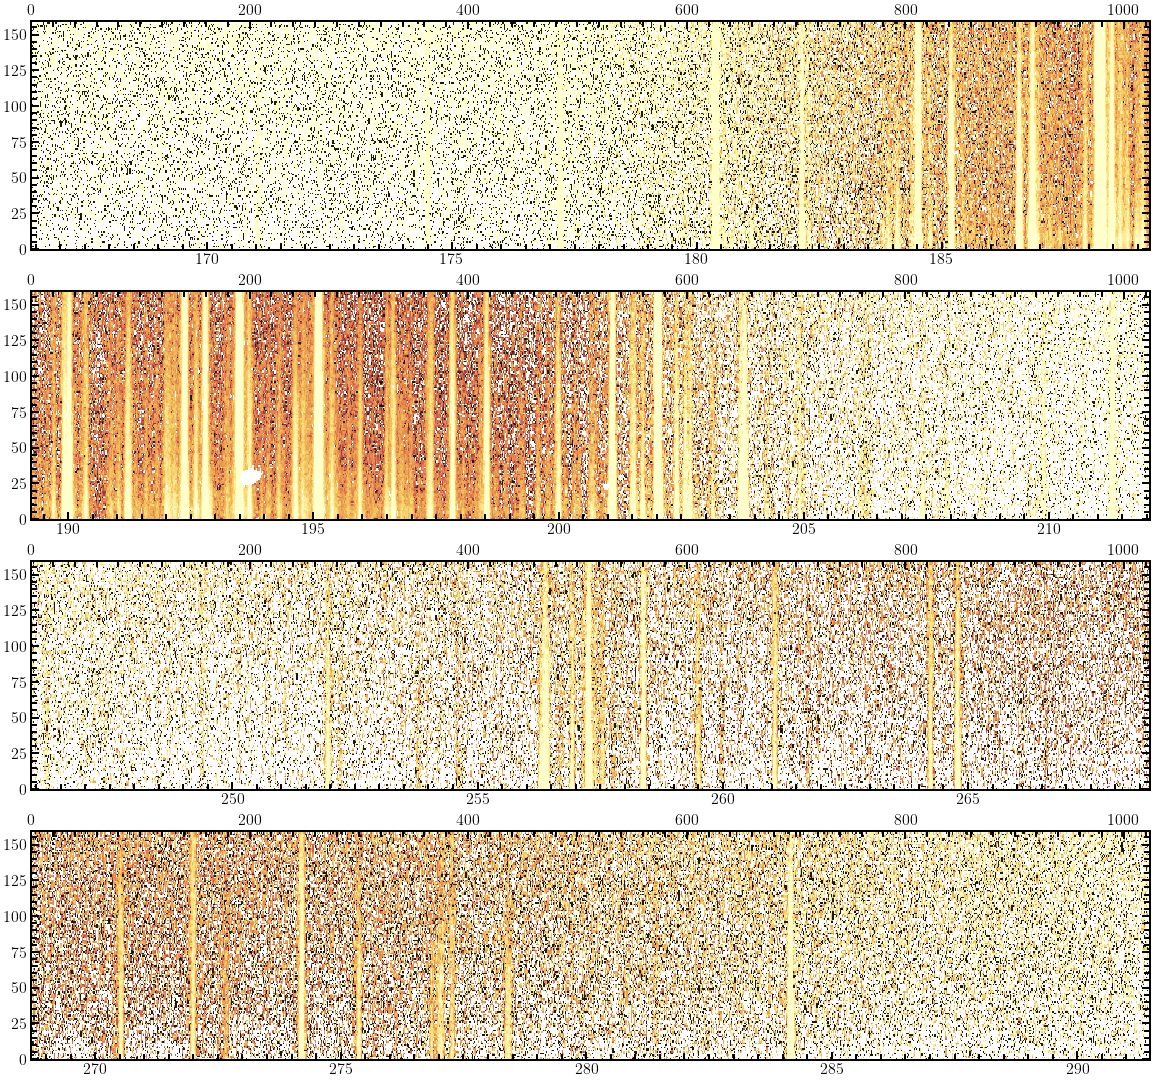

In [23]:
fig, axes = plt.subplots(4,1,figsize=(16,15),constrained_layout=True)

data_cubes = (data_cube_0, data_cube_1, data_cube_2, data_cube_3)
for ii, data_cube_ in enumerate(data_cubes):
    axes[ii].pcolormesh((data_cube_.wavelength)[:,0,:],np.tile(np.arange(160),(1024,1)).T,
                    np.nan_to_num(np.log10(data_cube_.data[:,15,:]),nan=-np.inf),
                    cmap=cmcm.lajolla_r,shading="auto",vmin=0,vmax=2.5)

    ax_pixel = axes[ii].twiny()
    ax_pixel.set_xlim(-0.5,1023.5)
    axes[ii].xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
    ax_pixel.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))

    for ax_ in (axes[ii], ax_pixel):
        ax_.tick_params(labelsize=16)
        ax_.tick_params(which="major",width=2,length=8)
        ax_.tick_params(which="minor",width=2,length=6)

In [9]:
def interp_window_slit_tilt(data,wvl):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        f = interp1d(wvl[ii,:],data[ii,:],kind="cubic",fill_value="extrapolate")
        data_interp[ii,:] = f(wvl[0,:])
    
    return data_interp

In [10]:
data_0_interp = np.zeros_like(data_cube_0.data)
for ii in range(60):
    data_0_interp[:,ii,:] = interp_window_slit_tilt(data_cube_0.data[:,ii,:],data_cube_0.wavelength[:,ii,:])

In [11]:
data_1_interp = np.zeros_like(data_cube_1.data)
for ii in range(60):
    data_1_interp[:,ii,:] = interp_window_slit_tilt(data_cube_1.data[:,ii,:],data_cube_1.wavelength[:,ii,:])

In [12]:
data_2_interp = np.zeros_like(data_cube_2.data)
for ii in range(60):
    data_2_interp[:,ii,:] = interp_window_slit_tilt(data_cube_2.data[:,ii,:],data_cube_2.wavelength[:,ii,:])

In [13]:
data_3_interp = np.zeros_like(data_cube_3.data)
for ii in range(60):
    data_3_interp[:,ii,:] = interp_window_slit_tilt(data_cube_3.data[:,ii,:],data_cube_3.wavelength[:,ii,:])

In [14]:
FeX_184_radcorr_hpw = 1.25465
FeX_184_radcorr_gdz = 1.35044
FeX_257_radcorr_hpw = 1.70066
FeX_257_radcorr_gdz = 2.89774
FeXI_188_radcorr_hpw = 0.979529
FeXI_188_radcorr_gdz = 1.44743
FeXI_257_radcorr_hpw = 1.69542
FeXI_257_radcorr_gdz = 2.87326
FeXII_186_radcorr_hpw = 1.07798
FeXII_186_radcorr_gdz = 1.40138
FeXII_192_radcorr_hpw = 0.833634
FeXII_192_radcorr_gdz = 1.12736
FeXII_195_radcorr_hpw = 0.874023
FeXII_195_radcorr_gdz = 1.00102
SiX_258_radcorr_hpw = 1.68540
SiX_258_radcorr_gdz = 2.79741
SiX_261_radcorr_hpw = 1.73463
SiX_261_radcorr_gdz = 2.67270
FeXIV_264_radcorr_hpw = 2.03844
FeXIV_264_radcorr_gdz = 2.46965

In [15]:
slit_width_aver = np.mean(data_cube_2.meta["slit_width"])

In [16]:
data_0_interp.shape

(160, 60, 1024)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


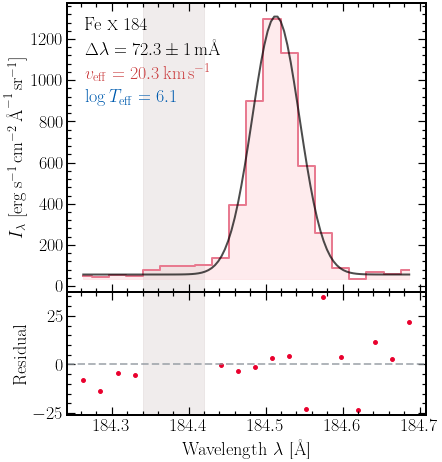

In [24]:
FeX_184_slice = slice(800,820)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeX_184_bin_ = data_masked[:,:15,FeX_184_slice]
FeX_184_bin_ = np.nanmean(FeX_184_bin_,axis=(0,1))


FeX_184_bin_fit_model = SpectrumFitCustomPlot(data=FeX_184_bin_, wvl=data_cube_0.wavelength[0,0,FeX_184_slice],
                                        line_number=1,line_wvl_init=[184.5],int_max_init=[1e3],fwhm_init=[0.07],
                                        mask=[[184.34,184.42]])
FeX_184_bin_fit_model.run_lse()
ax, ax_res = FeX_184_bin_fit_model.plot_custom(plot_params=False,
    xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
    ylabel=r"$I_\lambda\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,\mbox{\AA}^{-1}\,sr^{-1}]}$",
    )
ax.text(0.05,0.95,r'Fe \textsc{x} 184',fontsize=18,transform=ax.axes.transAxes,ha="left",va="top")

ax.text(0.05,0.87,r'$\Delta \lambda = {:.1f}\pm{:.1g}$\,m\mbox{{\AA}}'.format(num2tex(FeX_184_bin_fit_model.fwhm_fit[0]*1e3),
num2tex(FeX_184_bin_fit_model.fwhm_err[0]*1e3)),fontsize=18,transform=ax.axes.transAxes,ha="left",va="top")
ax_res.set_ylabel(r"$\boldsymbol{r}$",fontsize=18)

ax.text(0.05,0.79,r'$v_{{\rm eff}} = {:.1f}\,\mathrm{{km\,s^{{-1}}}}$'.format(num2tex(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - slit_width**2)/184.537/np.sqrt(4*np.log(2))*c/1e5)),
fontsize=18,transform=ax.axes.transAxes,ha="left",va="top",color="#CB4042")

ax.text(0.05,0.70,r'$\log T_{{\rm eff}} = {:.1f}$'.format(num2tex(np.log10((np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - slit_width**2)/184.537/np.sqrt(4*np.log(2))*c)**2*\
                    55.85*amu/2/k_b))),
fontsize=18,transform=ax.axes.transAxes,ha="left",va="top",color="#005CAF")

# ax.text(0.05,0.71,r"$v_{{\rm eff}}' = {:.1f}\,\mathrm{{km\,s^{{-1}}}}$".format(num2tex(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - 0.062**2)/184.537/np.sqrt(4*np.log(2))*c/1e5)),
# fontsize=18,transform=ax.axes.transAxes,ha="left",va="top",color="#005CAF")

ax_res.set_ylabel(r"Residual",fontsize=18)
plt.savefig(fname="../../slides/reg_meet/figs/FeX_184_example.png",format="png",dpi=240)

In [14]:
FeX_184_rest_wvl = 184.537
print(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - slit_width_aver**2)/ FeX_184_rest_wvl\
                    *const.c.cgs.value/1e5/np.sqrt(4*np.log(2)))
print(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - 0.062**2)/ FeX_184_rest_wvl\
                    *const.c.cgs.value/1e5/np.sqrt(4*np.log(2)))

19.675599422533576
35.93688291940894


<AxesSubplot:ylabel='Intensity'>

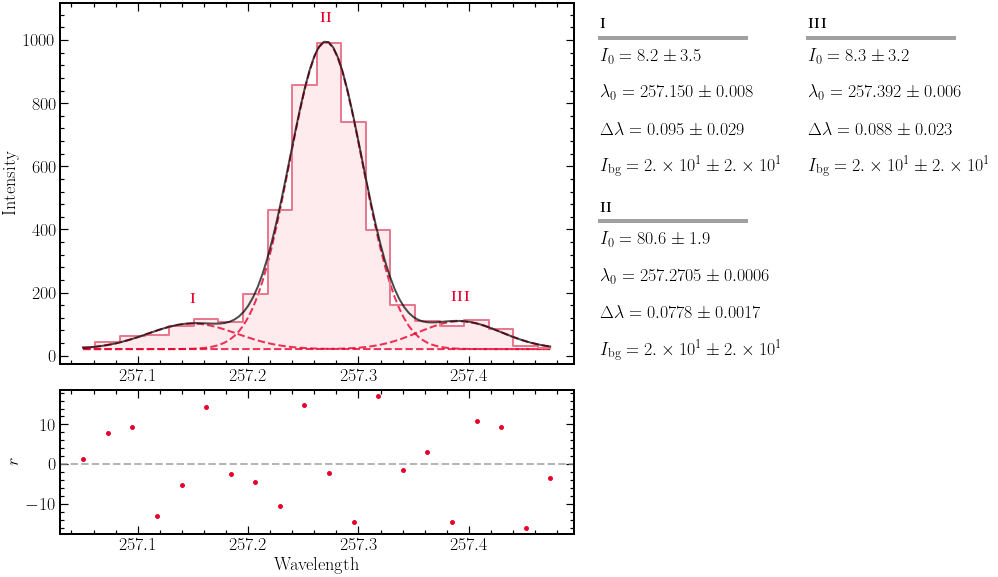

In [15]:
FeX_257_slice = slice(500,520)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeX_257_bin_ = data_masked[:,:,FeX_257_slice]
FeX_257_bin_ = np.nanmean(FeX_257_bin_,axis=(0,1))


FeX_257_bin_fit_model = SpectrumFitSingle(data=FeX_257_bin_, wvl=data_cube_2.wavelength[0,0,FeX_257_slice],
                                        line_number=3,line_wvl_init=[257.15,257.25,257.4],int_max_init=[1e2,1e3,1e2],fwhm_init=[0.07,0.07,0.07],
                                        )
# FeX_257_bin_fit_model.plot(plot_fit=False)
FeX_257_bin_fit_model.run_lse()
FeX_257_bin_fit_model.plot()

In [16]:
def chianti_interp_func(filename,diag="dens"):
    df_ratio = pd.read_csv(filename,skiprows=6,
                names=[diag,"ratio"],sep="\s+",index_col=False,dtype=np.float64)

    interp_func = interpolate.interp1d(df_ratio["ratio"].values, df_ratio[diag].values,kind="cubic",
                                    fill_value="extrapolate")

    return interp_func

In [17]:
FeX_184_257_interp_func_85 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_85.txt")
FeX_184_257_interp_func_90 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_90.txt")
FeX_184_257_interp_func_95 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_95.txt")

In [18]:
print(FeX_184_257_interp_func_85((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_85((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.758998289923184 6.123636996722028


In [19]:
print(FeX_184_257_interp_func_90((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_90((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.5763083196528385 5.93901222160505


In [20]:
print(FeX_184_257_interp_func_95((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_95((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.409577351598547 5.654177368595501


<AxesSubplot:ylabel='Intensity'>

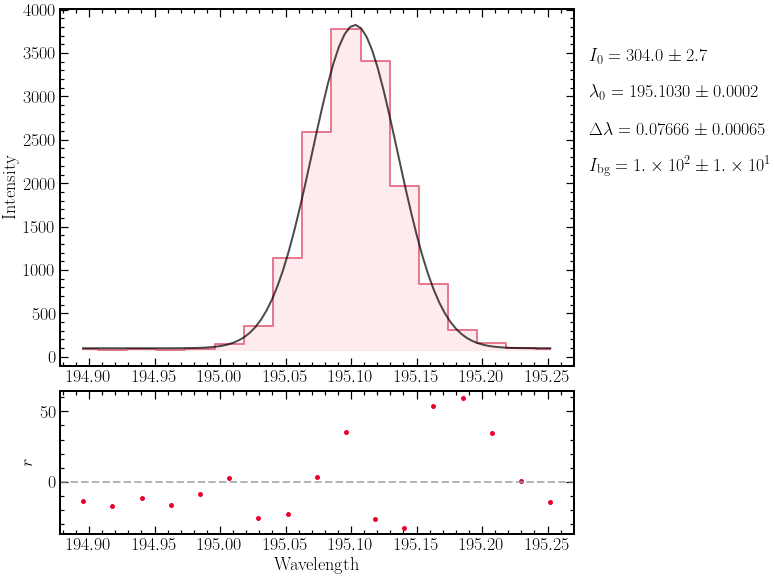

In [21]:
FeXII_195_slice = slice(253,270)
data_masked = np.copy(data_1_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_195_bin_ = data_masked[:,:,FeXII_195_slice]
FeXII_195_bin_ = np.nanmean(FeXII_195_bin_,axis=(0,1))


FeXII_195_bin_fit_model = SpectrumFitSingle(data=FeXII_195_bin_, wvl=data_cube_1.wavelength[0,0,FeXII_195_slice],line_number=1,
                                            line_wvl_init=[195.1],int_max_init=[5e3],fwhm_init=[0.08])
FeXII_195_bin_fit_model.run_lse()
FeXII_195_bin_fit_model.plot()

<AxesSubplot:ylabel='Intensity'>

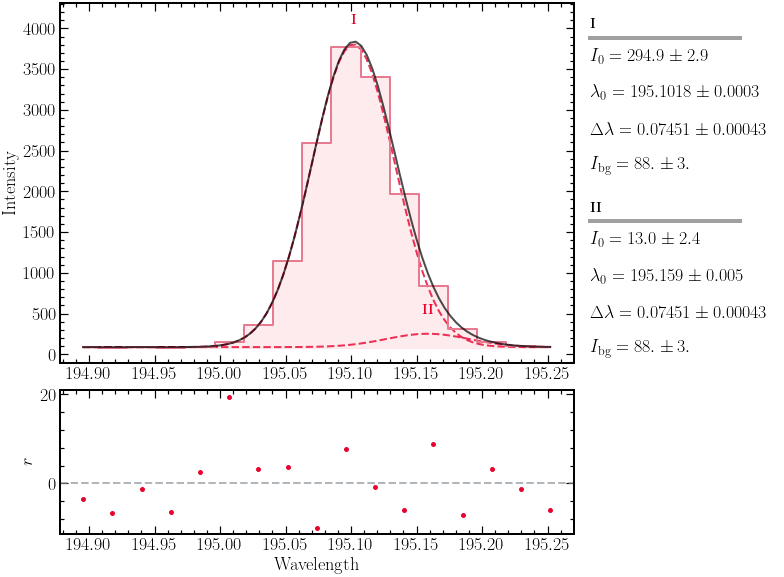

In [22]:
FeXII_195_slice = slice(253,270)
data_masked = np.copy(data_1_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_195_bin_ = data_masked[:,:,FeXII_195_slice]
FeXII_195_bin_ = np.nanmean(FeXII_195_bin_,axis=(0,1))


FeXII_195_bin_fit_model_double = SpectrumFitSingle(data=FeXII_195_bin_, wvl=data_cube_1.wavelength[0,0,FeXII_195_slice],line_number=2,
                                            line_wvl_init=[195.1,195.18],int_max_init=[5e3,1e2],fwhm_init=[0.08],same_width=True)
FeXII_195_bin_fit_model_double.run_lse()
FeXII_195_bin_fit_model_double.plot()

<AxesSubplot:ylabel='Intensity'>

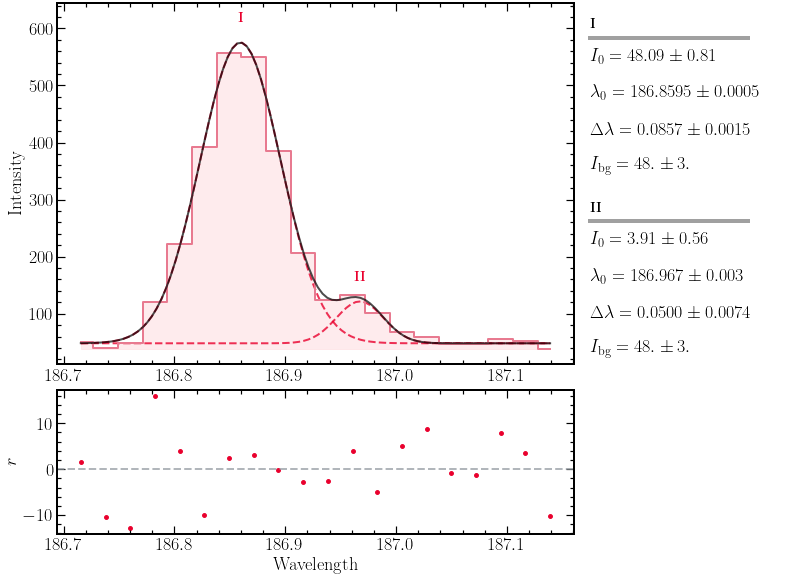

In [23]:
FeXII_186_slice = slice(910,930)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_186_bin_ = data_masked[:,:,FeXII_186_slice]
FeXII_186_bin_ = np.nanmean(FeXII_186_bin_,axis=(0,1))


FeXII_186_bin_fit_model = SpectrumFitSingle(data=FeXII_186_bin_, wvl=data_cube_0.wavelength[0,0,FeXII_186_slice],line_number=2,
                                            line_wvl_init=[186.85,186.95],int_max_init=[1e5,1e2],fwhm_init=[0.07,0.07])
FeXII_186_bin_fit_model.run_lse()
FeXII_186_bin_fit_model.plot()

<AxesSubplot:ylabel='Intensity'>

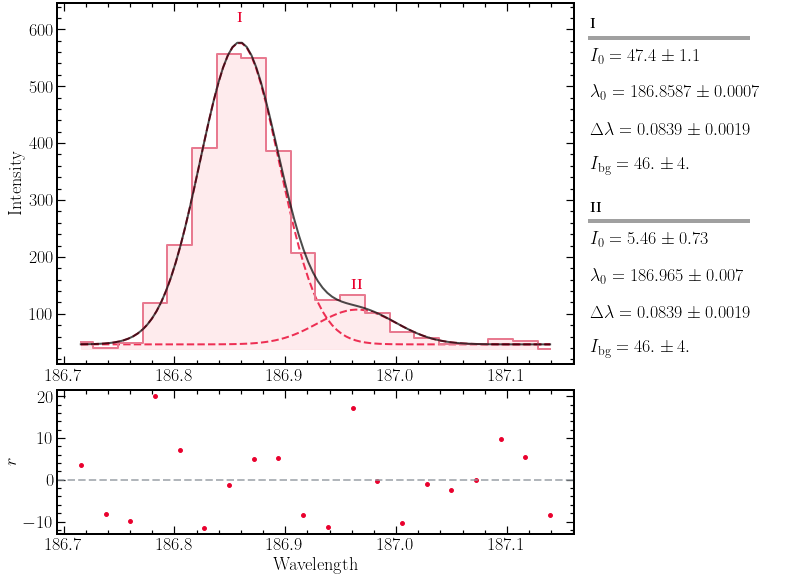

In [24]:
FeXII_186_slice = slice(910,930)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_186_bin_ = data_masked[:,:,FeXII_186_slice]
FeXII_186_bin_ = np.nanmean(FeXII_186_bin_,axis=(0,1))


FeXII_186_bin_fit_model_sw = SpectrumFitSingle(data=FeXII_186_bin_, wvl=data_cube_0.wavelength[0,0,FeXII_186_slice],line_number=2,
                                            line_wvl_init=[186.85,186.95],int_max_init=[1e5,1e2],fwhm_init=[0.07],same_width=True)
FeXII_186_bin_fit_model_sw.run_lse()
FeXII_186_bin_fit_model_sw.plot()

In [25]:
FeXII_195_186_interp_func = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeXII_195_186_dens.txt")

In [26]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.55418736216157 8.45088499417361


In [27]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model_double.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model_double.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.579959949956205 8.475075917353298


In [28]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model_sw.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model_sw.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.541578997406114 8.439044701894668


<AxesSubplot:ylabel='Intensity'>

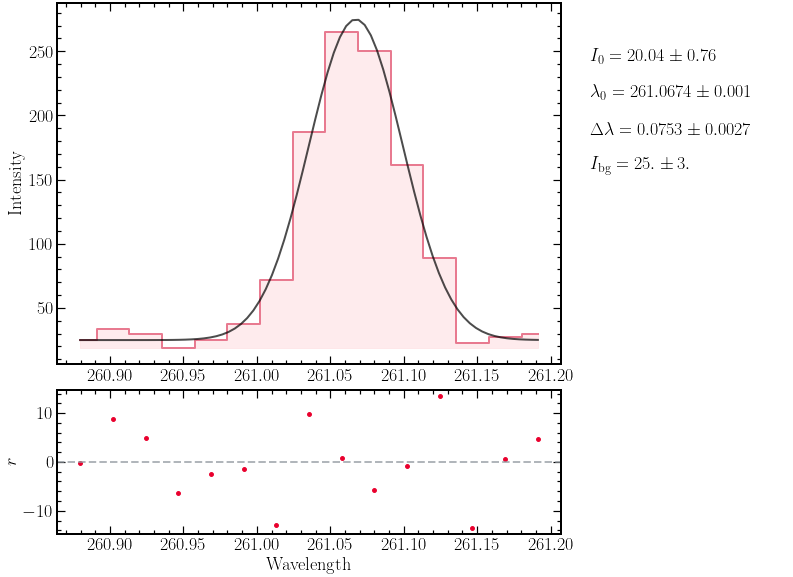

In [29]:
SiX_261_slice = slice(672,687)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
SiX_261_bin_ = data_masked[:,:,SiX_261_slice]
SiX_261_bin_ = np.nanmean(SiX_261_bin_,axis=(0,1))


SiX_261_bin_fit_model = SpectrumFitSingle(data=SiX_261_bin_, wvl=data_cube_2.wavelength[0,0,SiX_261_slice],line_number=1,
                                            line_wvl_init=[261.06],int_max_init=[3e2],fwhm_init=[0.08])
SiX_261_bin_fit_model.run_lse()
SiX_261_bin_fit_model.plot()

<AxesSubplot:ylabel='Intensity'>

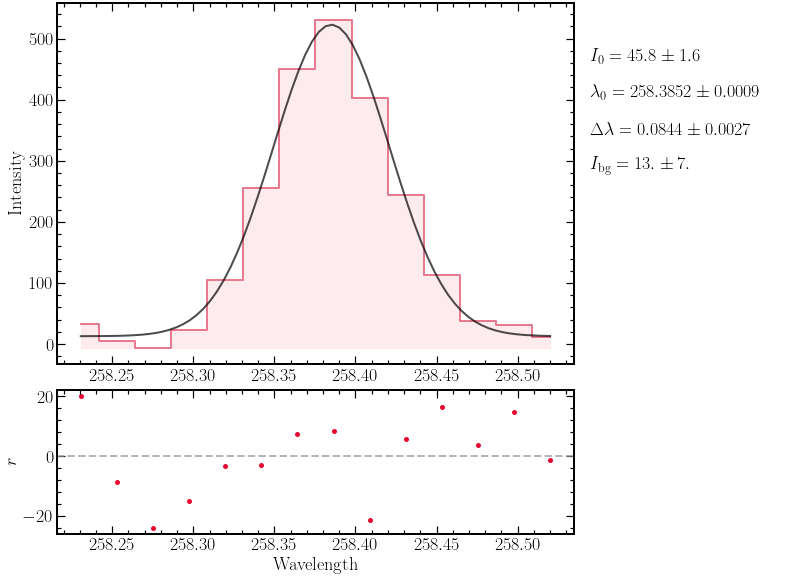

In [30]:
SiX_258_slice = slice(553,567)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
SiX_258_bin_ = data_masked[:,:,SiX_258_slice]
SiX_258_bin_ = np.nanmean(SiX_258_bin_,axis=(0,1))


SiX_258_bin_fit_model = SpectrumFitSingle(data=SiX_258_bin_, wvl=data_cube_2.wavelength[0,0,SiX_258_slice],line_number=1,
                                            line_wvl_init=[258.38],int_max_init=[3e2],fwhm_init=[0.08])
SiX_258_bin_fit_model.run_lse()
SiX_258_bin_fit_model.plot()

In [31]:
SiX_261_258_interp_func = chianti_interp_func("../../sav/CHIANTI/line_ratio/SiX_261_258_dens.txt")

In [32]:
print(SiX_261_258_interp_func((SiX_261_bin_fit_model.int_total_fit[0]*SiX_261_radcorr_gdz)/ \
                (SiX_258_bin_fit_model.int_total_fit[0]*SiX_258_radcorr_gdz)),
SiX_261_258_interp_func((SiX_261_bin_fit_model.int_total_fit[0]*SiX_261_radcorr_hpw)/ \
                (SiX_258_bin_fit_model.int_total_fit[0]*SiX_258_radcorr_hpw)))

8.753062354508407 8.617704363783115


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:208: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


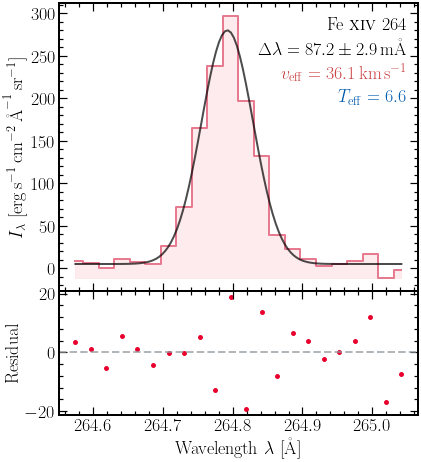

In [102]:
FeXIV_264_slice = slice(838,860)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXIV_264_bin_ = data_masked[:,:,FeXIV_264_slice]
FeXIV_264_bin_ = np.nanmean(FeXIV_264_bin_,axis=(0,1))


FeXIV_264_bin_fit_model = SpectrumFitCustomPlot(data=FeXIV_264_bin_, wvl=data_cube_2.wavelength[0,0,FeXIV_264_slice],
                                        line_number=1,line_wvl_init=[264.8],int_max_init=[1e3],fwhm_init=[0.07])
FeXIV_264_bin_fit_model.run_lse()
ax, ax_res = FeXIV_264_bin_fit_model.plot_custom(plot_params=False,
    xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
    ylabel=r"$I_\lambda\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,\mbox{\AA}^{-1}\,sr^{-1}]}$",
    )
ax.text(0.97,0.95,r'Fe \textsc{xiv} 264',fontsize=18,transform=ax.axes.transAxes,ha="right",va="top")

ax.text(0.97,0.87,r'$\Delta \lambda = {:.1f}\pm{:.2g}$\,m\mbox{{\AA}}'.format(num2tex(FeXIV_264_bin_fit_model.fwhm_fit[0]*1e3),
num2tex(FeXIV_264_bin_fit_model.fwhm_err[0]*1e3)),fontsize=18,transform=ax.axes.transAxes,ha="right",va="top")
ax_res.set_ylabel(r"$\boldsymbol{r}$",fontsize=18)

ax.text(0.97,0.79,r'$v_{{\rm eff}} = {:.1f}\,\mathrm{{km\,s^{{-1}}}}$'.format(num2tex(np.sqrt(FeXIV_264_bin_fit_model.fwhm_fit[0]**2 - slit_width**2)/264.788/np.sqrt(4*np.log(2))*c/1e5)),
fontsize=18,transform=ax.axes.transAxes,ha="right",va="top",color="#CB4042")

ax.text(0.97,0.70,r'$T_{{\rm eff}} = {:.1f}$'.format(num2tex(np.log10((np.sqrt(FeXIV_264_bin_fit_model.fwhm_fit[0]**2 - slit_width**2)/264.788/np.sqrt(4*np.log(2))*c)**2*\
                        55.85*amu/2/k_b))),
fontsize=18,transform=ax.axes.transAxes,ha="right",va="top",color="#005CAF")

# ax.text(0.97,0.71,r"$v_{{\rm eff}}' = {:.1f}\,\mathrm{{km\,s^{{-1}}}}$".format(num2tex(np.sqrt(FeXIV_264_bin_fit_model.fwhm_fit[0]**2 - 0.062**2)/264.788/np.sqrt(4*np.log(2))*c/1e5)),
# fontsize=18,transform=ax.axes.transAxes,ha="right",va="top",color="#005CAF")

ax_res.set_ylabel(r"Residual",fontsize=18)
plt.savefig(fname="../../slides/reg_meet/figs/FeXIV_264_example.png",format="png",dpi=240)